In [1]:
def findexact(str, substr, index=0):
  offset = str.find(substr)
  ln = len(substr)
  if not index:
    return offset
  return offset + ln + findexact(str[offset+ln :], substr, index-1)

def multifind(str, substrs):
  ret = len(str)
  for substr in substrs:
    index = findexact(str, substr)
    if index > -1 and index < ret:
      ret = index
  if ret == len(str):
    ret = -1
  return ret

In [2]:
!pip install gdown --quiet
!pip install docx2txt --quiet
!pip install pymorphy2 --quiet

import string
import gdown
import docx2txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
from wordcloud import WordCloud

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix

nltk.download('punkt')
nltk.download('stopwords')

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 48.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
!gdown 12PfGMG4aAXA-dTJ3QmhN0crpqf_4WyZb

txt = docx2txt.process("CCXXXI: la Guirlande de Julie.docx")

Downloading...
From: https://drive.google.com/uc?id=12PfGMG4aAXA-dTJ3QmhN0crpqf_4WyZb
To: /content/CCXXXI: la Guirlande de Julie.docx
100% 656k/656k [00:00<00:00, 18.7MB/s]


In [4]:
months = ["vendémiaire", "brumaire", "frimaire", "nivôse", "pluviôse", "ventôse",
          "germinal", "floréal", "prairial", "messidor", "thermidor", "fructidor", "complémentaires"]
for month in months:
  txt = txt.replace(month.upper(), "")

labels = ["monologue", "story", "fanfic", "chguestk", "moretta", "letter", "lyrics"]

df = pd.DataFrame(columns=["name", "day", "month", "greg_day", "greg_month", "label", "text"])

while(multifind(txt, labels) != -1):
  start = multifind(txt, labels)
  label = txt[start : txt.find(" ", start)]
  txt = txt[start + len(label) :]
  day = pd.Series({
      "name" : txt[findexact(txt, " ", 3) + 1 : findexact(txt, "\n")],
      "day" : int(txt[findexact(txt, " ", 1) + 1 : findexact(txt, " ", 2)]),
      "month" : txt[findexact(txt, " ", 2) + 1 : findexact(txt, ".", 1)],
      "greg_day" : int(txt[findexact(txt, "(") + 1 : findexact(txt, ".")]),
      "greg_month" : int(txt[findexact(txt, ".") + 1 : findexact(txt, ")")]),
      "label" : label,
      "text" : txt[findexact(txt, "\n", 1) + 1 : multifind(txt, labels)],
      "sentences" : None,
  })
  df = pd.concat([df, day.to_frame().T], ignore_index=True)

In [5]:
df["words"] = df["text"].map(lambda x: len(x.replace("-", "").split()))
df["symbols"] = df["text"].map(lambda x: len(x.replace(" ", "")))
df["capitals"] = df["text"].map(lambda x: len(list(filter(lambda c: c.isupper(), x))))
df["dashes"] = df["text"].map(lambda x: len(list(filter(lambda w: w == "-", x.split()))))
df["questions"] = df["text"].map(lambda x: len(list(filter(lambda c: c == "?", x))))
df["exclamations"] = df["text"].map(lambda x: len(list(filter(lambda c: c == "!", x))))
df["newlines"] = df["text"].map(lambda x: len(list(filter(lambda c: c == "\n", x))))
df["text"] = df["text"].map(lambda x: " ".join(x.split()))

df["sentences"] = df["text"].map(lambda x: len(x.replace("?", ".").replace("!", ".").replace("…", ".").split(". ")))

In [6]:
df

,name,day,month,greg_day,greg_month,label,text,sentences,words,symbols,capitals,dashes,questions,exclamations,newlines
0,raisin,1,vendémiaire,23,9,monologue,люди не изменились. ароматная жидкость мягко к...,17,238,1361,0,4,2,0,22
1,safran,2,vendémiaire,24,9,story,Сафран горд своим прозвищем. нет большого смыс...,21,333,1954,5,3,1,1,14
2,châtaigne,3,vendémiaire,25,9,story,Кристине исполняется четыре года. белокурая ма...,30,514,2838,10,13,5,2,14
3,colchique,4,vendémiaire,26,9,story,с тихим звонком открываются двери лифта. мягки...,39,339,1947,30,12,6,2,40
4,cheval,5,vendémiaire,27,9,story,Келлер Долль привычным движением запрыгивает в...,22,374,2266,10,4,0,0,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,colza,27,thermidor,15,8,monologue,"они, конечно же, позовут опять. возникнут из н...",11,295,1560,0,9,0,0,6
327,lupin,28,thermidor,16,8,moretta,"казалось бы, должно быть очевидно, что всё это...",12,306,1742,1,5,4,0,10
328,coton,29,thermidor,17,8,monologue,"люди - вершина цепочки питания, соединяющая до...",14,293,1924,0,6,1,0,6
329,moulin,30,thermidor,18,8,story,"Анри шагал по улице, легонько помахивая тросто...",12,350,2005,3,8,1,0,13


In [7]:
df[df["label"] == "letter"]#.sort_values(by=["words"], ascending=False)

,name,day,month,greg_day,greg_month,label,text,sentences,words,symbols,capitals,dashes,questions,exclamations,newlines
37,scorsonère,8,brumaire,30,10,letter,одной неожиданной фразы или случайного взгляда...,15,321,1870,0,5,0,0,14
74,chevreuil,15,frimaire,6,12,letter,"мама, где ты? я не вижу тебя нигде до самого г...",12,316,1619,0,5,1,0,10
84,grillon,25,frimaire,16,12,letter,"ого, уже так поздно? никогда не успеваю привык...",29,360,1998,2,7,3,2,14
95,lave,6,nivôse,27,12,letter,"я знаю, что этим ничего не исправить - даже ес...",14,372,1959,1,6,0,0,10
112,fer,23,nivôse,13,1,letter,"кажется, так обычно описывают эффект от каких-...",17,293,1594,0,8,3,0,18
125,laurier tin,6,pluviôse,26,1,letter,"вот она, твоя хвалёная зима. чего же в ней хор...",12,256,1424,0,6,2,0,6
130,ellébore,11,pluviôse,31,1,letter,"я отлично знаю, что должна делать. весь вчераш...",18,271,1556,0,4,0,0,14
134,vache,15,pluviôse,4,2,letter,снова тяжëлый вздох и прикрытые ладонью глаза ...,18,300,1655,0,5,0,0,6
154,bouc,5,ventôse,24,2,letter,"привет. как дела? хотя нет, не говори. я не см...",26,423,2265,0,6,3,0,14
157,violette,8,ventôse,27,2,letter,"вот он и настал снова, этот день. нет уже радо...",16,327,1741,0,6,2,0,10


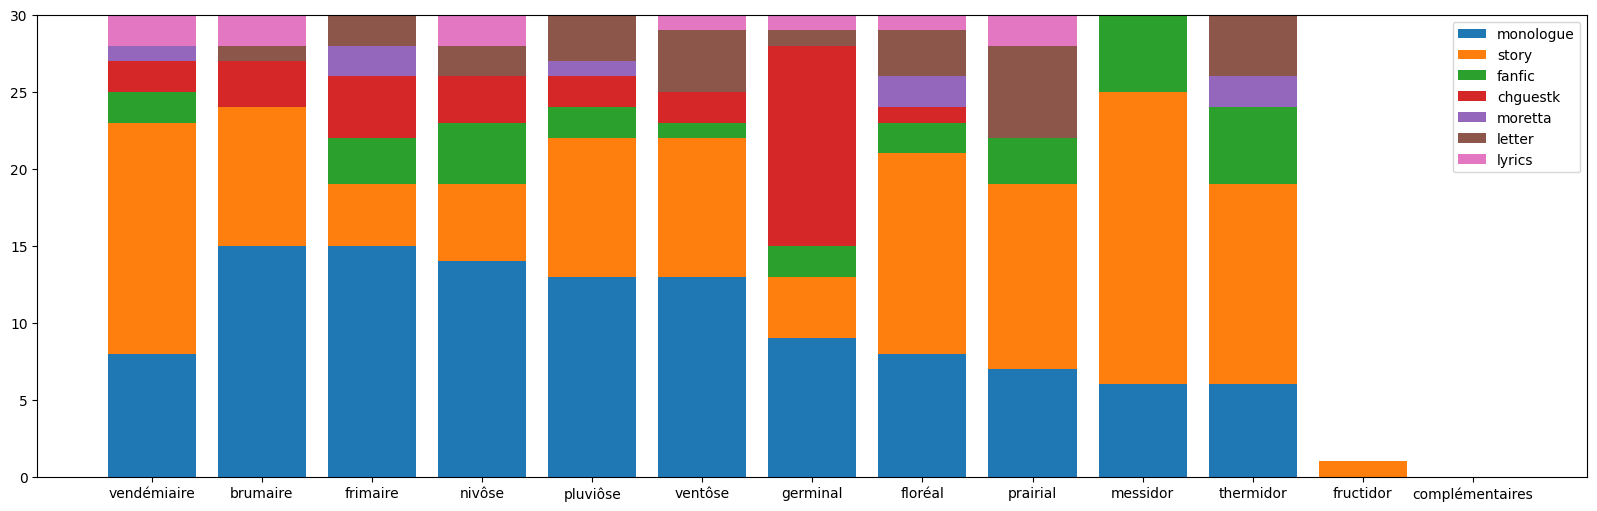

In [9]:
fig = plt.figure(figsize=(20, 6))
bottom = np.zeros(len(months))
for label in labels:
  count = np.empty(0)
  for month in months:
    count = np.append(count, df[(df["month"] == month) & (df["label"] == label)].shape[0])
  plt.bar(np.asarray(months), count, label=label, bottom=bottom)
  bottom += count
plt.legend()
plt.show()

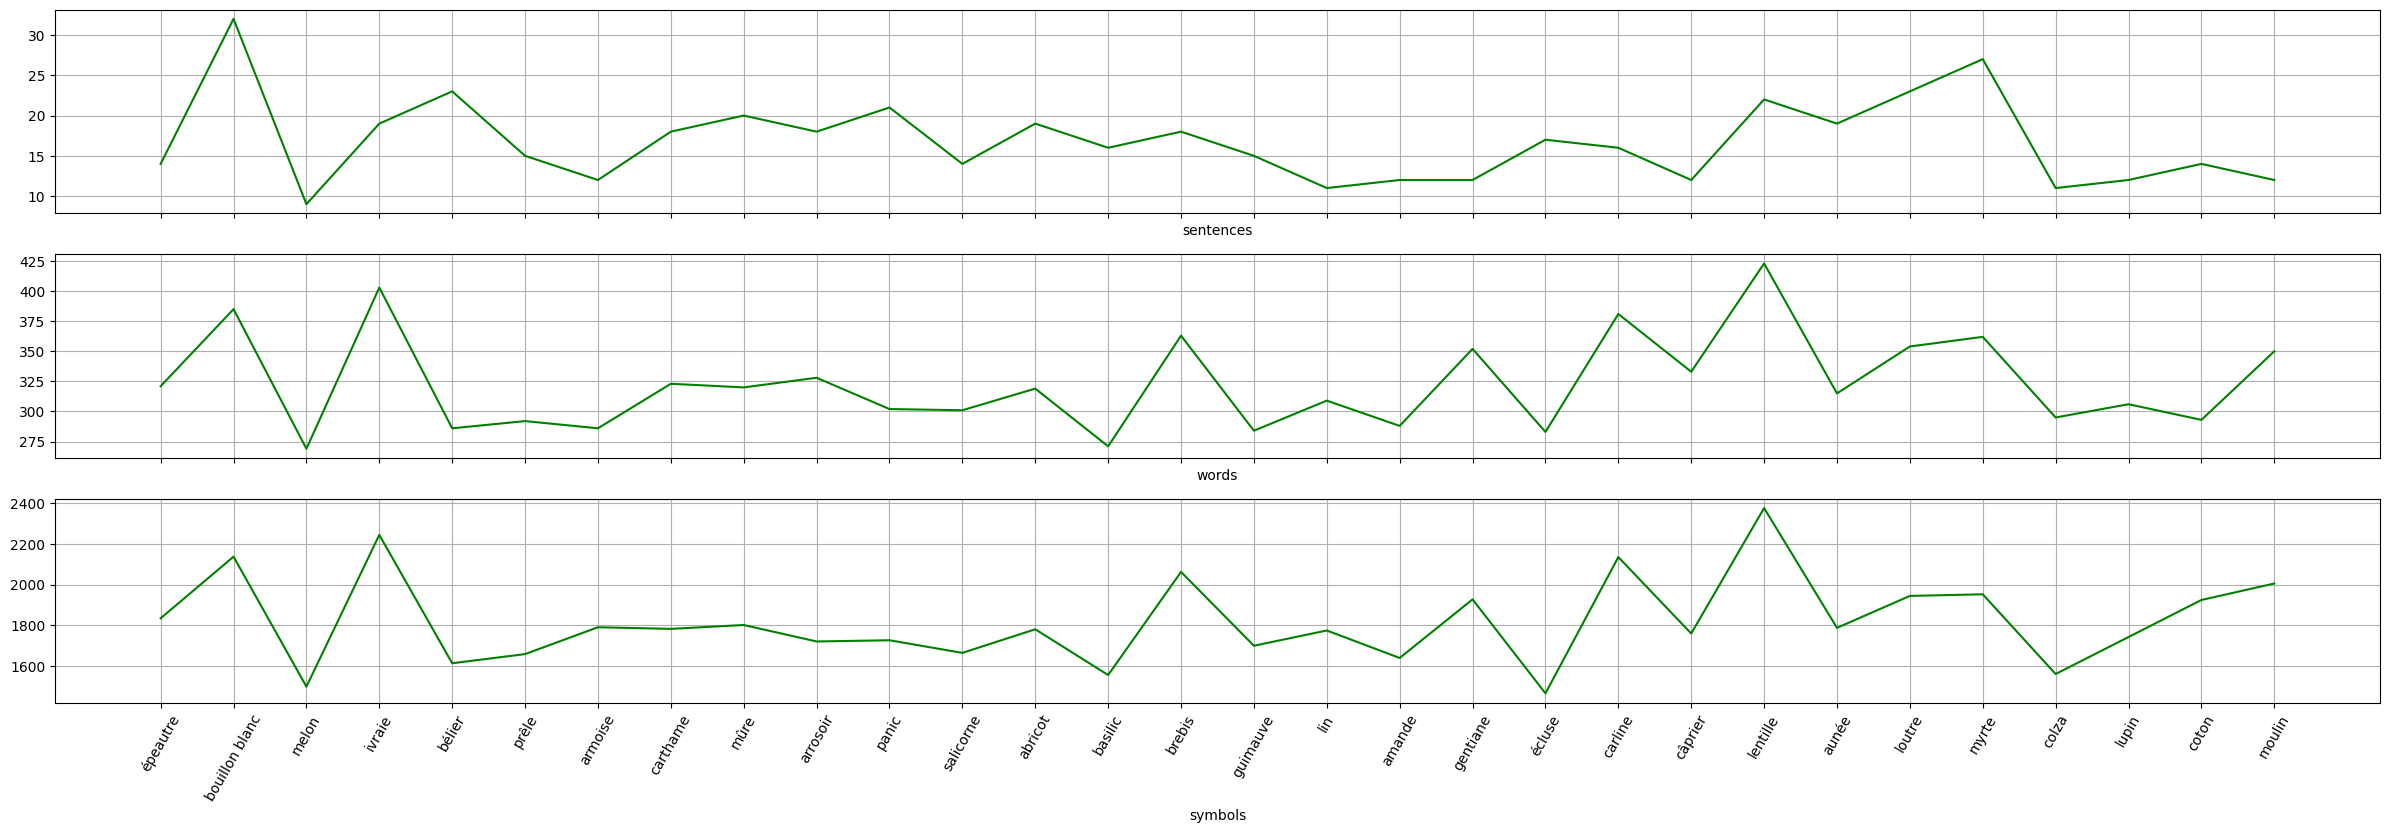

In [10]:
batch = df[df["month"] == months[10]]

plots = ["sentences", "words", "symbols"]
# plots = ["capitals", "dashes", "questions", "exclamations", "newlines"]
fig, axs = plt.subplots(len(plots), 1, sharex=True, figsize=(batch.shape[0], 3 * len(plots)))
for i in range(len(plots)):
  axs[i].plot(batch["name"], batch[plots[i]], 'g')
  axs[i].set_xlabel(plots[i])
  axs[i].grid()
plt.xticks(rotation=60)
plt.show()

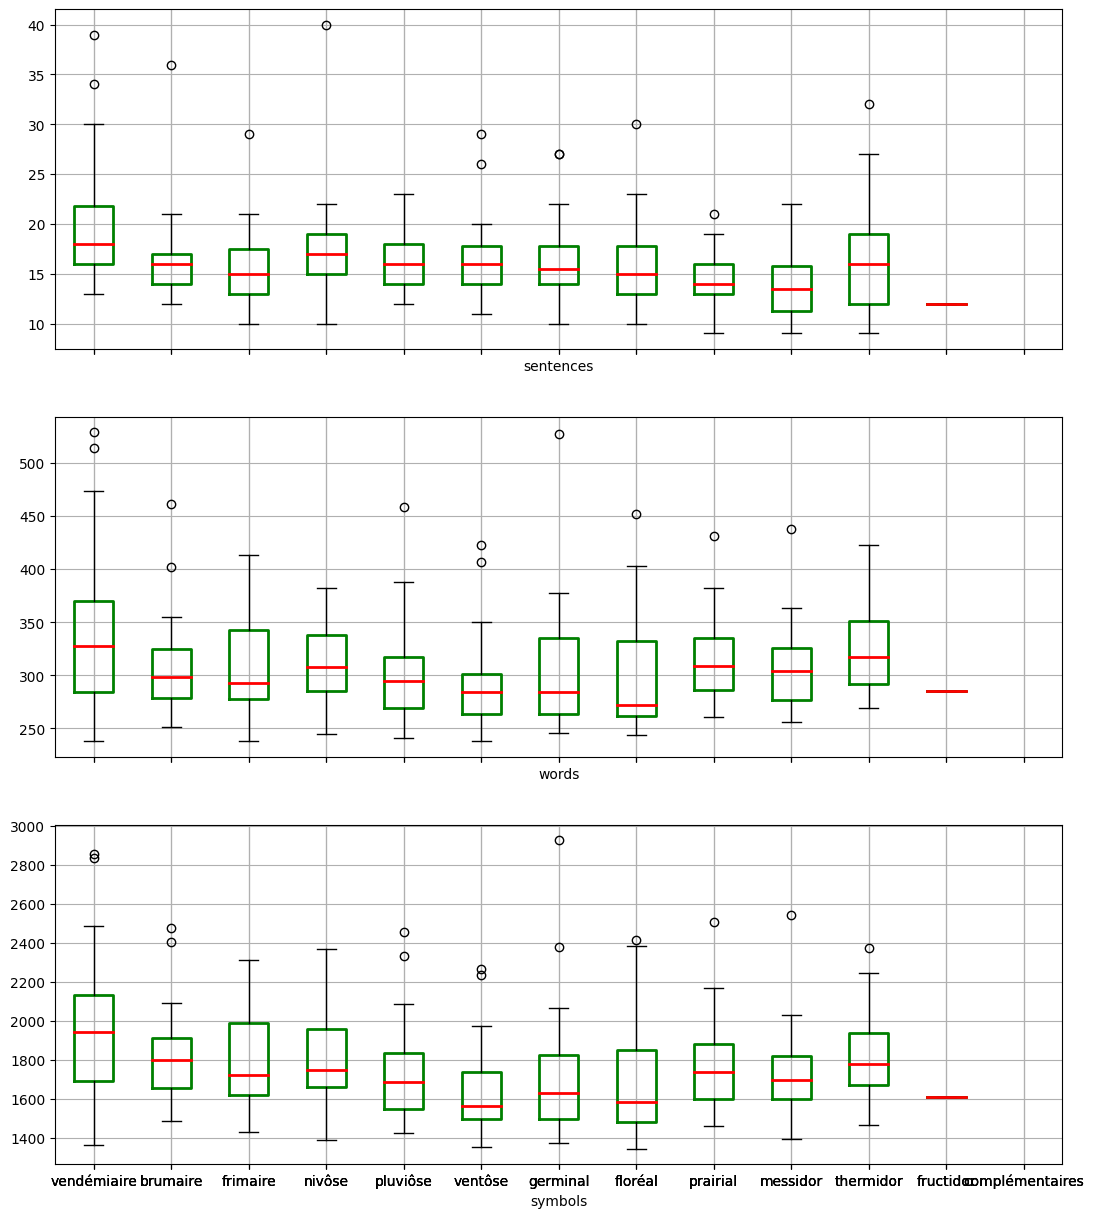

In [14]:
boxprops = dict(linewidth=2, color='g')
medianprops = dict(linewidth=2, color='r')

plots = ["sentences", "words", "symbols"]
fig, axs = plt.subplots(len(plots), 1, sharex=True, figsize=(13, 5 * len(plots)))
for i in range(len(plots)):
  stat = pd.DataFrame(columns=months)
  for month in months:
    stat[month] = df[df["month"] == month][plots[i]].reset_index(drop=True)
    stat[month].fillna(stat[month].mean(), inplace=True)
  axs[i].boxplot(stat.to_numpy(), labels=stat.columns, widths=0.5, boxprops=boxprops, medianprops=medianprops)
  axs[i].set_xlabel(plots[i])
  axs[i].grid()
plt.suptitle("")
plt.show()

linreg MSE:  -4.191474950034846e+16
ridge MSE:  5.090145298527558


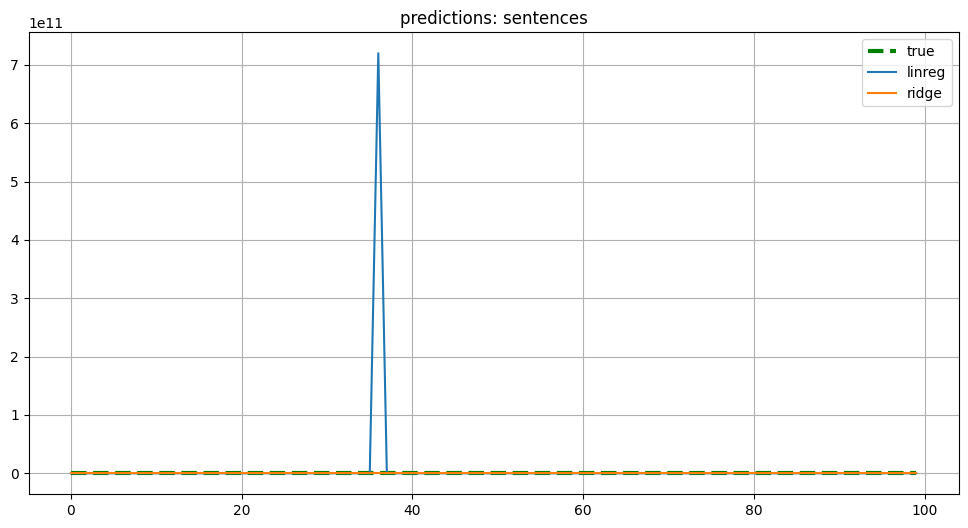

In [15]:
target_column = "sentences"
dum_df = pd.get_dummies(data=df, columns=["month", "label"]).drop(columns=["name", "text"])
X, y = dum_df.drop(columns=[target_column]), dum_df[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=88)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

params = np.arange(0, 150, 1)
loss = []
for p in params:
  model = Ridge(alpha=p, random_state=88).fit(X_train, y_train)
  y_pred = model.predict(X_test)
  loss.append(mean_squared_error(y_test, y_pred))
alpha = params[np.argmin(loss)]

reg = LinearRegression().fit(X_train, y_train)
y_pred_reg = reg.predict(X_test).astype(int)
ridge = Ridge(alpha=alpha, random_state=88).fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

print("linreg MSE: ", mean_squared_error(y_test, y_pred_reg))
print("ridge MSE: ", mean_squared_error(y_test, y_pred_ridge))

fig = plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label="true", color='g', linewidth=3, linestyle="dashed")
plt.plot(range(len(y_pred_reg)), y_pred_reg, label="linreg")
plt.plot(range(len(y_pred_ridge)), y_pred_ridge, label="ridge")
plt.title("predictions: " + target_column)
plt.grid()
plt.legend()
plt.show()

<Axes: >

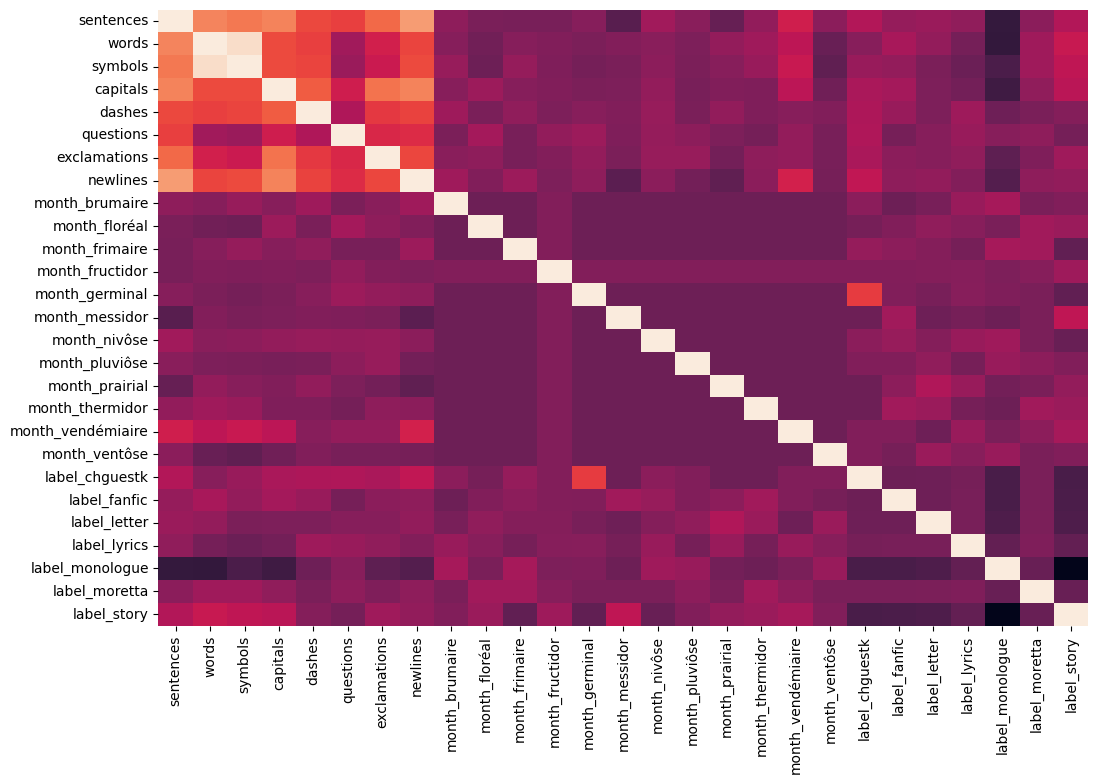

In [16]:
fig = plt.figure(figsize=(12, 8))
sns.heatmap(dum_df.corr(numeric_only=True), cbar=False)

In [17]:
print("chguestk by month:\n")
for month in months:
    print(month + ": " + str(df[(df["label"] == "chguestk") & (df["month"] == month)].shape[0]))

chguestk by month:

vendémiaire: 2
brumaire: 3
frimaire: 4
nivôse: 3
pluviôse: 2
ventôse: 2
germinal: 13
floréal: 1
prairial: 0
messidor: 0
thermidor: 0
fructidor: 0
complémentaires: 0


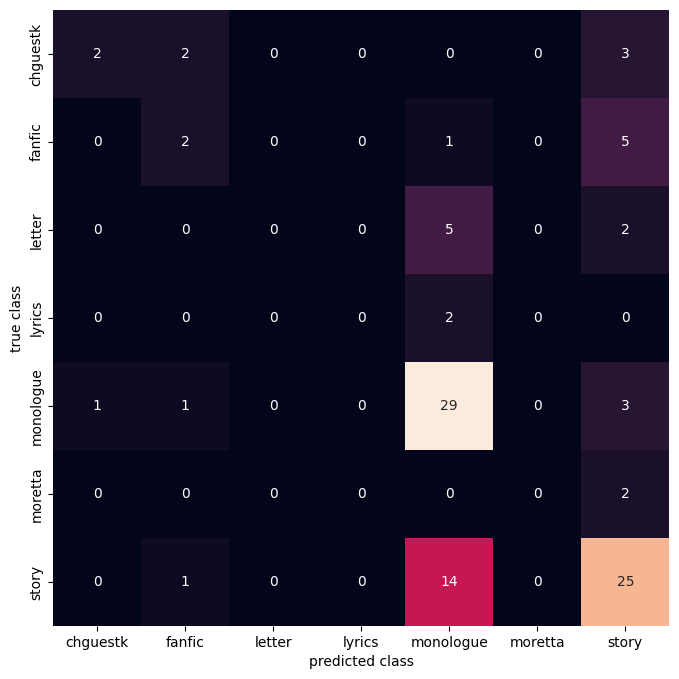

In [18]:
target_column = "label"
clf_dum_df = pd.get_dummies(data=df, columns=["month"]).drop(columns=["name", "text"])
X, y = clf_dum_df.drop(columns=[target_column]), clf_dum_df[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=88)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

clf = RandomForestClassifier(random_state=88).fit(X_train, y_train)
y_pred_clf = clf.predict(X_test)

# print("accuracy: ", classification_report(y_test, y_pred_clf, labels=clf.classes_, zero_division=0, output_dict=True)["accuracy"])

fig = plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix(y_test, y_pred_clf, labels=clf.classes_),
            xticklabels=clf.classes_, yticklabels=clf.classes_, annot=True, cbar=False, square=True)
plt.xlabel("predicted class")
plt.ylabel("true class")
plt.show()

(-0.5, 7999.5, 3999.5, -0.5)

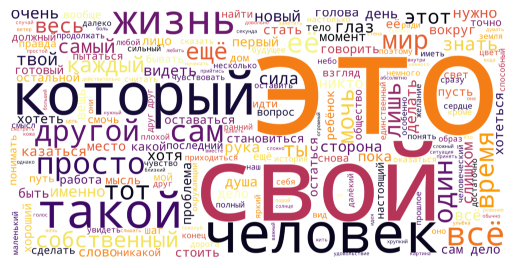

In [19]:
text_to_tokenize = " ".join(df["text"])
stop_words = set(stopwords.words("russian"))
tokens = word_tokenize(text_to_tokenize, language="russian")
tokens = [token.lower() for token in tokens if not token in stop_words and token.isalpha()]

morph = MorphAnalyzer()
tokens = [morph.normal_forms(token)[0] for token in tokens]
text_to_plot = " ".join(tokens)

wordcloud = WordCloud(
    stopwords=[],
    regexp=None,
    normalize_plurals=False,
    max_words=200,
    width=800,
    height=400,
    scale=10,
    relative_scaling=1,
    background_color="white",
    colormap="inferno",
    ).generate(text_to_plot)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

In [53]:
def make_pairs(ind_words):
    for i in range(len(ind_words) - 1):
        yield (ind_words[i], ind_words[i + 1])

markov_words = " ".join(df[df["label"] == "story"]["text"]).split()

markov_pairs = make_pairs(markov_words)
markov_dict = {}
for word_1, word_2 in markov_pairs:
    if word_1 in markov_dict.keys():
        markov_dict[word_1].append(word_2)
    else:
        markov_dict[word_1] = [word_2]

chain = [np.random.choice(markov_words)]
for i in range(100):
  chain.append(np.random.choice(markov_dict[chain[-1]]))
print(' '.join(chain))

силу своих собственных увлечений на её основную, “элитную” компанию. поэтому я очень горячо утверждают, что рано или в смысле ценных вещей, - такое уж он видит сияющие на глубину инстинкта. но ты просил меня энергию жить своими страстями и те понимают, что твои скупые враги - подчиняясь направлению ветра. я всё общество разом, критически мало. да: минимум экономического неравенства, что можно было шансов, поэтому ты сам привыкаешь к хорошим примером - до некоторой степени гипнотизировать, но всё знал. и постепенно превращаться в безопасности самое великолепное благовоние, что не проглотил бы сам себе. не за другом за кулисами. правда, многое извлекается из
